In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import time
import numpy as np
use_cuda = True
batch_size = 500

In [12]:
from _invertible import *

In [13]:
unorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [15]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

Files already downloaded and verified


In [17]:
from _invertible import ConvAutoencoder, Flatten, Unflatten, Crop

encoder = nn.Sequential(
  nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(),
  nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
  nn.BatchNorm2d(256),
  nn.ReLU(),
  nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
  nn.BatchNorm2d(512),
  nn.ReLU(),
  nn.Conv2d(512, 128, kernel_size=3, stride=2, padding=1),
)

decoder = nn.Sequential(
  nn.ConvTranspose2d(128, 512, kernel_size=4, stride=2, padding=1),
  nn.BatchNorm2d(512),
  nn.ReLU(),
  nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
  nn.BatchNorm2d(256),
  nn.ReLU(),
  nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(),
  nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
  nn.Sigmoid(),
)

torch.Size([500, 3, 32, 32])

In [33]:
model = ConvAutoencoder(encoder, decoder).cuda()
opt = optim.Adam(model.parameters(), lr=2e-3)
epochs = 150
scheduler = optim.lr_scheduler.StepLR(opt, epochs // 3, gamma=0.1, last_epoch=-1)
criterion = torch.nn.MSELoss()

In [34]:
for epoch in range(epochs):

  print('epoch %s' % epoch)
  t = time.time()
  model.train()
  train_loss = 0
  for i, (img, label) in enumerate(trainloader):
    img = img.cuda()
    z = model.forward(img)
    x_hat = model.reverse(z)
    loss = criterion(img[:,:,2:-2,2:-2], x_hat[:,:,2:-2,2:-2])
    train_loss += loss
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if (i+1) % 10 == 0:
      print('{:.4f},'.format(train_loss/10.),end='',flush=True)
      train_loss = 0
  print('')
  print('training epoch took {:.4f}'.format(time.time() - t))

  # test loop
  # --------------------------------------------------------------------------
  model.eval()
  with torch.no_grad():
    total_loss = 0
    for i, (img, label) in enumerate(testloader): 
      img = img.cuda() 
      z = model.forward(img)
      x_hat = model.reverse(z)
      total_loss += criterion(img[:,:,2:-2,2:-2], x_hat[:,:,2:-2,2:-2])
      
    print('avg test loss: {}'.format(total_loss / i))
  scheduler.step()

epoch 0
0.0033,0.0018,0.0014,0.0013,0.0012,0.0011,0.0010,0.0011,0.0010,0.0010,
training epoch took 10.1974
avg test loss: 0.00117663259152323
epoch 1
0.0010,0.0010,0.0011,0.0010,0.0010,0.0010,0.0010,0.0011,0.0011,0.0010,
training epoch took 10.2892
avg test loss: 0.0011648554354906082
epoch 2
0.0011,0.0010,0.0010,0.0010,0.0010,0.0011,0.0010,0.0011,0.0011,0.0010,
training epoch took 10.3721
avg test loss: 0.0011365688405930996
epoch 3
0.0010,0.0010,0.0011,0.0010,0.0011,0.0011,0.0011,0.0010,0.0011,0.0010,
training epoch took 10.3816
avg test loss: 0.0010812514228746295
epoch 4
0.0010,0.0010,0.0010,0.0010,0.0010,0.0011,0.0010,0.0010,0.0010,0.0010,
training epoch took 10.3955
avg test loss: 0.001129408716224134
epoch 5
0.0011,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0011,0.0011,0.0010,
training epoch took 10.3952
avg test loss: 0.0011176277184858918
epoch 6
0.0011,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,
training epoch took 10.4964
avg test loss: 0.001209060777910

avg test loss: 0.0008181548328138888
epoch 57
0.0008,0.0008,0.0008,0.0008,0.0007,0.0007,0.0008,0.0008,0.0008,0.0008,
training epoch took 10.9691
avg test loss: 0.0008146534091793001
epoch 58
0.0008,0.0007,0.0008,0.0007,0.0008,0.0008,0.0008,0.0008,0.0007,0.0007,
training epoch took 10.9873
avg test loss: 0.0008086220477707684
epoch 59
0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0007,
training epoch took 10.9005
avg test loss: 0.0008111292263492942
epoch 60
0.0008,0.0008,0.0008,0.0008,0.0007,0.0008,0.0008,0.0008,0.0008,0.0007,
training epoch took 10.7960
avg test loss: 0.0008114197407849133
epoch 61
0.0008,0.0008,0.0007,0.0008,0.0008,0.0008,0.0008,0.0008,0.0007,0.0008,
training epoch took 10.6763
avg test loss: 0.0008086998132057488
epoch 62
0.0007,0.0008,0.0008,0.0008,0.0008,0.0007,0.0008,0.0007,0.0008,0.0008,
training epoch took 10.8645
avg test loss: 0.0008151316433213651
epoch 63
0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,
training epoc

In [23]:
x = next(iter(testloader))

In [42]:
z = model.forward(x[0].cuda())
x_hat = model.reverse(z)

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.utils as tutils
def show(img, w=12, h=4):
  if isinstance(img, torch.Tensor):
    img = img.cpu().detach()
  npimg = img.numpy().transpose(1,2,0)
  fig, ax = plt.subplots(figsize=(w, h))
  print(npimg.shape)
  ax.imshow(npimg)
  plt.tight_layout()

In [44]:
im = x[0]

(62, 242, 3)


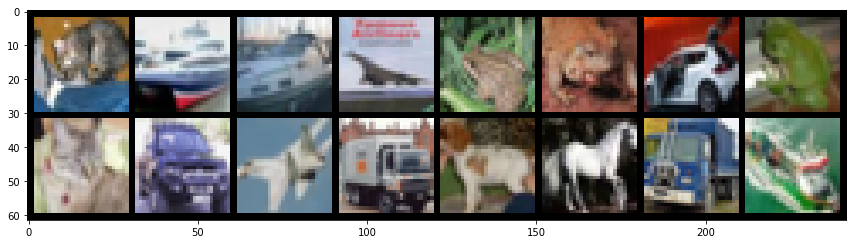

In [47]:
show(tutils.make_grid((im[:16,:,2:-2,2:-2])))

In [80]:
z = model.forward(x[0].cuda())
x_hat = model.reverse(z * 1.5)

(62, 242, 3)


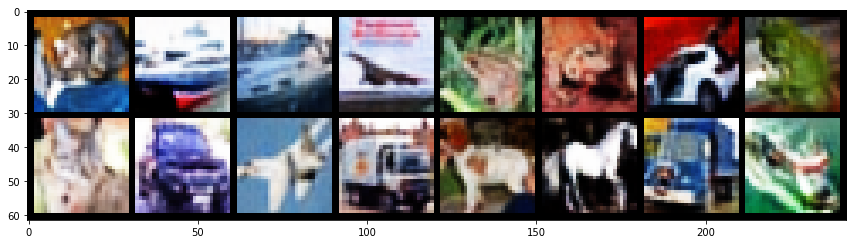

In [81]:
show(tutils.make_grid((x_hat[:16,:,2:-2,2:-2].cpu())))

In [82]:
z.shape

torch.Size([1000, 128, 2, 2])

In [85]:
m = torch.randn(1024, 1024)

In [86]:
%%timeit
m.matmul(m)

2.11 ms ± 4.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%%timeit
torch.inverse(m)

7.94 ms ± 7.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
%%timeit
torch.inverse(m).matmul(m)

10.7 ms ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
%%timeit
m*m

81.7 µs ± 89 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [90]:
%%timeit
torch.solve(m, m)

8.04 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
